In [1102]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [1103]:
mean_interval,skew_interval,mean_overlap,skew_overlap = 0.012,0.14,0.003,0.035
var,var_no  =0.2,0.1
pos_th, neg_th, en_th = 0.4, 0.6, 10

In [1104]:

#Defines the intervals the mean and skew are bound by when a decision is being made 
def interval(mean_interval,skew_interval,mean_overlap,skew_overlap,mn,sk,ap):
    mean_min = mn-mean_interval-mean_overlap
    mean_max = mn+mean_interval+mean_overlap
    skew_min = sk-skew_interval-skew_overlap
    skew_max = sk+skew_interval+skew_overlap
    
    return[mean_min,mean_max,skew_min,skew_max]
    

In [1105]:
#Defines how the mean and skew will change during a decision, bound by the function above
def dec_no_ap(mean_ap,skew_ap,intervals):
    skew = skew_ap-0.0210
    mean = mean_ap - 0.0018

    mins = [intervals[2],intervals[0]]
    if skew< mins[0]:
        skew = mins[0]
    if mean < mins[1]:
        mean=mins[1]
    return [mean,skew]
    
def dec_yes_ap(mean_ap,skew_ap,intervals):
    skew = skew_ap + 0.0210
    mean = mean_ap + 0.0018

    maxs = [intervals[3],intervals[1]]
    if skew>maxs[0]:
        skew = maxs[0]
    if mean > maxs[1]:
        mean = maxs[1]
    return [mean,skew]

In [1106]:
#Defines the initial mean and skew for a given apathy to be used at the start of a simulation
def initial(ap,mean_interval,skew_interval,mean_overlap,skew_overlap):
    decimal = ap%1
    ap = int(ap)
    if ap>10 or ap<0:
        return 'error'

    
    if ap !=0 and ap!=9 and ap!=10:
        mn = 0.2 +mean_overlap-(ap)*mean_interval - (mean_interval+2*mean_overlap)*decimal
        sk = 0 +  skew_overlap-(ap)*skew_interval - (skew_interval+2*mean_overlap)*decimal
    
    elif ap==9:
        mn = 0.08+(mean_interval+mean_overlap)*(1-decimal) 
        sk = -10*skew_interval + (skew_interval+skew_overlap)*(1-decimal)
        
    elif ap==0:
        mn = 0.2 - (mean_interval+mean_overlap)*decimal
        sk = 0 - (mean_interval+mean_overlap)*decimal

    elif ap==10:
        mn = 0.08
        sk = -10*skew_interval
       
    return [mn,sk]



In [1107]:
#The process of making a decision to engage or not by sampling under the gaussian
# en is the energy usage
#while loop ensures no value greater than 1 
def decision_process(mean_ap,skew_ap,var_ap,var_no,ap):
    yes = no = 99
    while yes>1 and no>1:
        yes = stats.skewnorm.rvs(skew_ap,mean_ap,var_ap)
        no = np.random.normal(0,var_no)
        
        flg=0

        val = abs(yes-no)
        en = (0.1+ap*0.1)/val

        if en >1.5:
            en = 1.5
        if yes>no:
                flg=1

    return [flg,val,en,yes,no]

In [1108]:
#one entire decision
def one_decision(pos_th, neg_th, en_th, var, var_no,mn,sk,ap):
    
    rep = 0 #number of processes in the decision

    pos = 0 #value assigned to engaging, if it reaches pos_th the decision is engage
    neg = 0 #value of not engaging, if it reaches neg_th the decision is not engage
    en = 0  #value of energy used, if it reaches en_th the decision is not engage

    yes = 0 #total engage value sampled when it is greater than not engage
    no = 0  #total not engage value sampled when it is greater than engage
    ys = 0  #total times engage was greater
    n = 0   #total times not engage was greater

    en_flg = 0 #indicates if en reached en_th

    mn_dec = mn
    sk_dec = sk
    intervals = interval(mean_interval,skew_interval,mean_overlap,skew_overlap,mn,sk,ap)

    while pos < pos_th and neg < neg_th and en<en_th:
        res = decision_process(mn_dec,sk_dec,var,var_no,ap)

        if res[0] == 1:   #engage
            pos_change = dec_yes_ap(mn_dec,sk_dec,intervals)
            mn_dec = pos_change[0]
            sk_dec = pos_change[1]
            pos +=res[1]
            yes+=res[3]
            ys+=1 

        else: #disengage
            neg_change = dec_no_ap(mn_dec,sk_dec,intervals)
            mn_dec = neg_change[0]
            sk_dec = neg_change[1]
            neg +=res[1]
            no+=res[4]
            n+=1

        en+=res[2]
        rep+=1
        
    if en>en_th and pos<pos_th and neg<neg_th:
        en_flg = 1
    
    if n==0:
        n = 1
        no += res[4]
        
    return [pos,1,en,yes/ys,rep,en_flg,0] if pos>pos_th else [neg,0,en,no/n,rep,en_flg,(neg-pos)/rep]

In [1140]:
def day_decisions(ap , days, var, var_no,w):
    start = initial(ap,mean_interval,skew_interval,mean_overlap,skew_overlap)
    sk = start[1]
    
    #initial paramters to calculate the mean
    m1 = 0.2 
    m2 = 0.012
    
    no = 0 #total number of not engage decisions
    ys = 0 #total engage decisions made across all days
    flg = 1 #flag if the current decisions is engage, also used to indicate if the previous decision engaged
    en_flg = 0 #total number of exhausts from one decision in a day
    day_exhaust = 0 #number of complete exhaustions for a day
    
    #evolution over all days
    ev_mn=[]
    ev_sk=[]
    ev_ap =[]
    ev_pos_dec = []
    ev_neg_dec = []
    ev_rep = []
    ev_exhaust = []
    ev_day_exhaust = []

    for _ in range(days):

        day_en = 0
        dec = 0 # max of 10 decisions in a day
        yes = 0  #total engage decisions in a day
        day_en_th = fun_2(ap)

        while dec<10 and day_en<day_en_th:
            mn = mean(ap,m1,m2)
            out = one_decision(pos_th,neg_th,en_th, var, var_no ,mn,sk, ap)

            if out[1]==1 and flg ==1:
                flg_con = 1 # two engages in a row
            else:
                flg_con = 0

            flg = out[1]
            en_flg+=out[5]
            day_en+=out[2]
            rep=out[4] # deliberation of a decisions
            dec+=1

            if out[1] ==1:
                ys+=1
                yes+=1
            elif out[1]==0:
                no+=1
            new = param_learn(ap,m1,m2,out[3],flg,flg_con,w,out[6],sk) # learning process to update m1 (hence mean) skew and apathy
            m1 = new[0]
            sk+=new[1]
            ap+=new[2]

            
            if ap<0:
                ap = 0
            if ap>10:
                ap = 10

            ev_mn.append(mn)
            ev_sk.append(sk)
            ev_ap.append(ap)
            ev_pos_dec.append(ys)
            ev_neg_dec.append(no)
            ev_rep.append(rep)
            ev_exhaust.append(en_flg)
            
            
            
            day_en_th = fun_2(ap) #update daily en_th for new ap
            


        sk+=learn_sk(yes,w,ap) #update the skew after each day
        
        
        if day_en>day_en_th:
            for i in range(10-dec):
                en_flg+=1
                no+=1
                ev_mn.append(mn)
                ev_sk.append(sk)
                ev_ap.append(ap)
                ev_pos_dec.append(ys)
                ev_neg_dec.append(no)
                ev_exhaust.append(en_flg)
                day_exhaust+=1
        ev_day_exhaust.append(day_exhaust)

    return [ev_mn,ev_sk,ev_ap,ev_rep,ev_pos_dec,ev_neg_dec, ev_exhaust,ev_day_exhaust]


In [1147]:
def mean(ap,m1,m2):
    mu = m1-ap*m2
    return mu


def param_learn(ap,m1,m2,val,flg,flg_con,w,no,skew):
    del_sk = 0
    m1_new = m1

    l= 1

    if flg==1: #engage
        dif = (np.random.normal(0.3,var)*(1-ap/5)-val) #actual - predicted,   reward sensitivity is dependant on apathy
        m1_new = m1+w*dif*l
        if dif<0: 
            del_sk = -2/10*w*l #if engage is worse than expected skew negatively
            

    if flg==0:
        mn = mean(ap,m1,m2)
        m, vr, sk, kurt = stats.skewnorm.stats(skew,mn,0.2, moments='mvsk')
        
        del_mn = mn - (var_no**2*0+mn*vr**2)/(var_no**2+vr**2) # multiplication of current and not engage gaussians, without updating var
        m1_new = m1 - del_mn*w*l
        
    #If two consecutive engages apathy improves (towards 0), if currently not engaging apathy gets worse, else no change
    del_ap = -w
    if flg_con ==0:
        del_ap*=-1 
        if flg == 1:
            del_ap = 0
    

   
    return(m1_new,del_sk,del_ap)

def learn_sk(engage,w,ap):
    l = 1
    del_sk = (engage-5)/10*w*l
    return(del_sk)





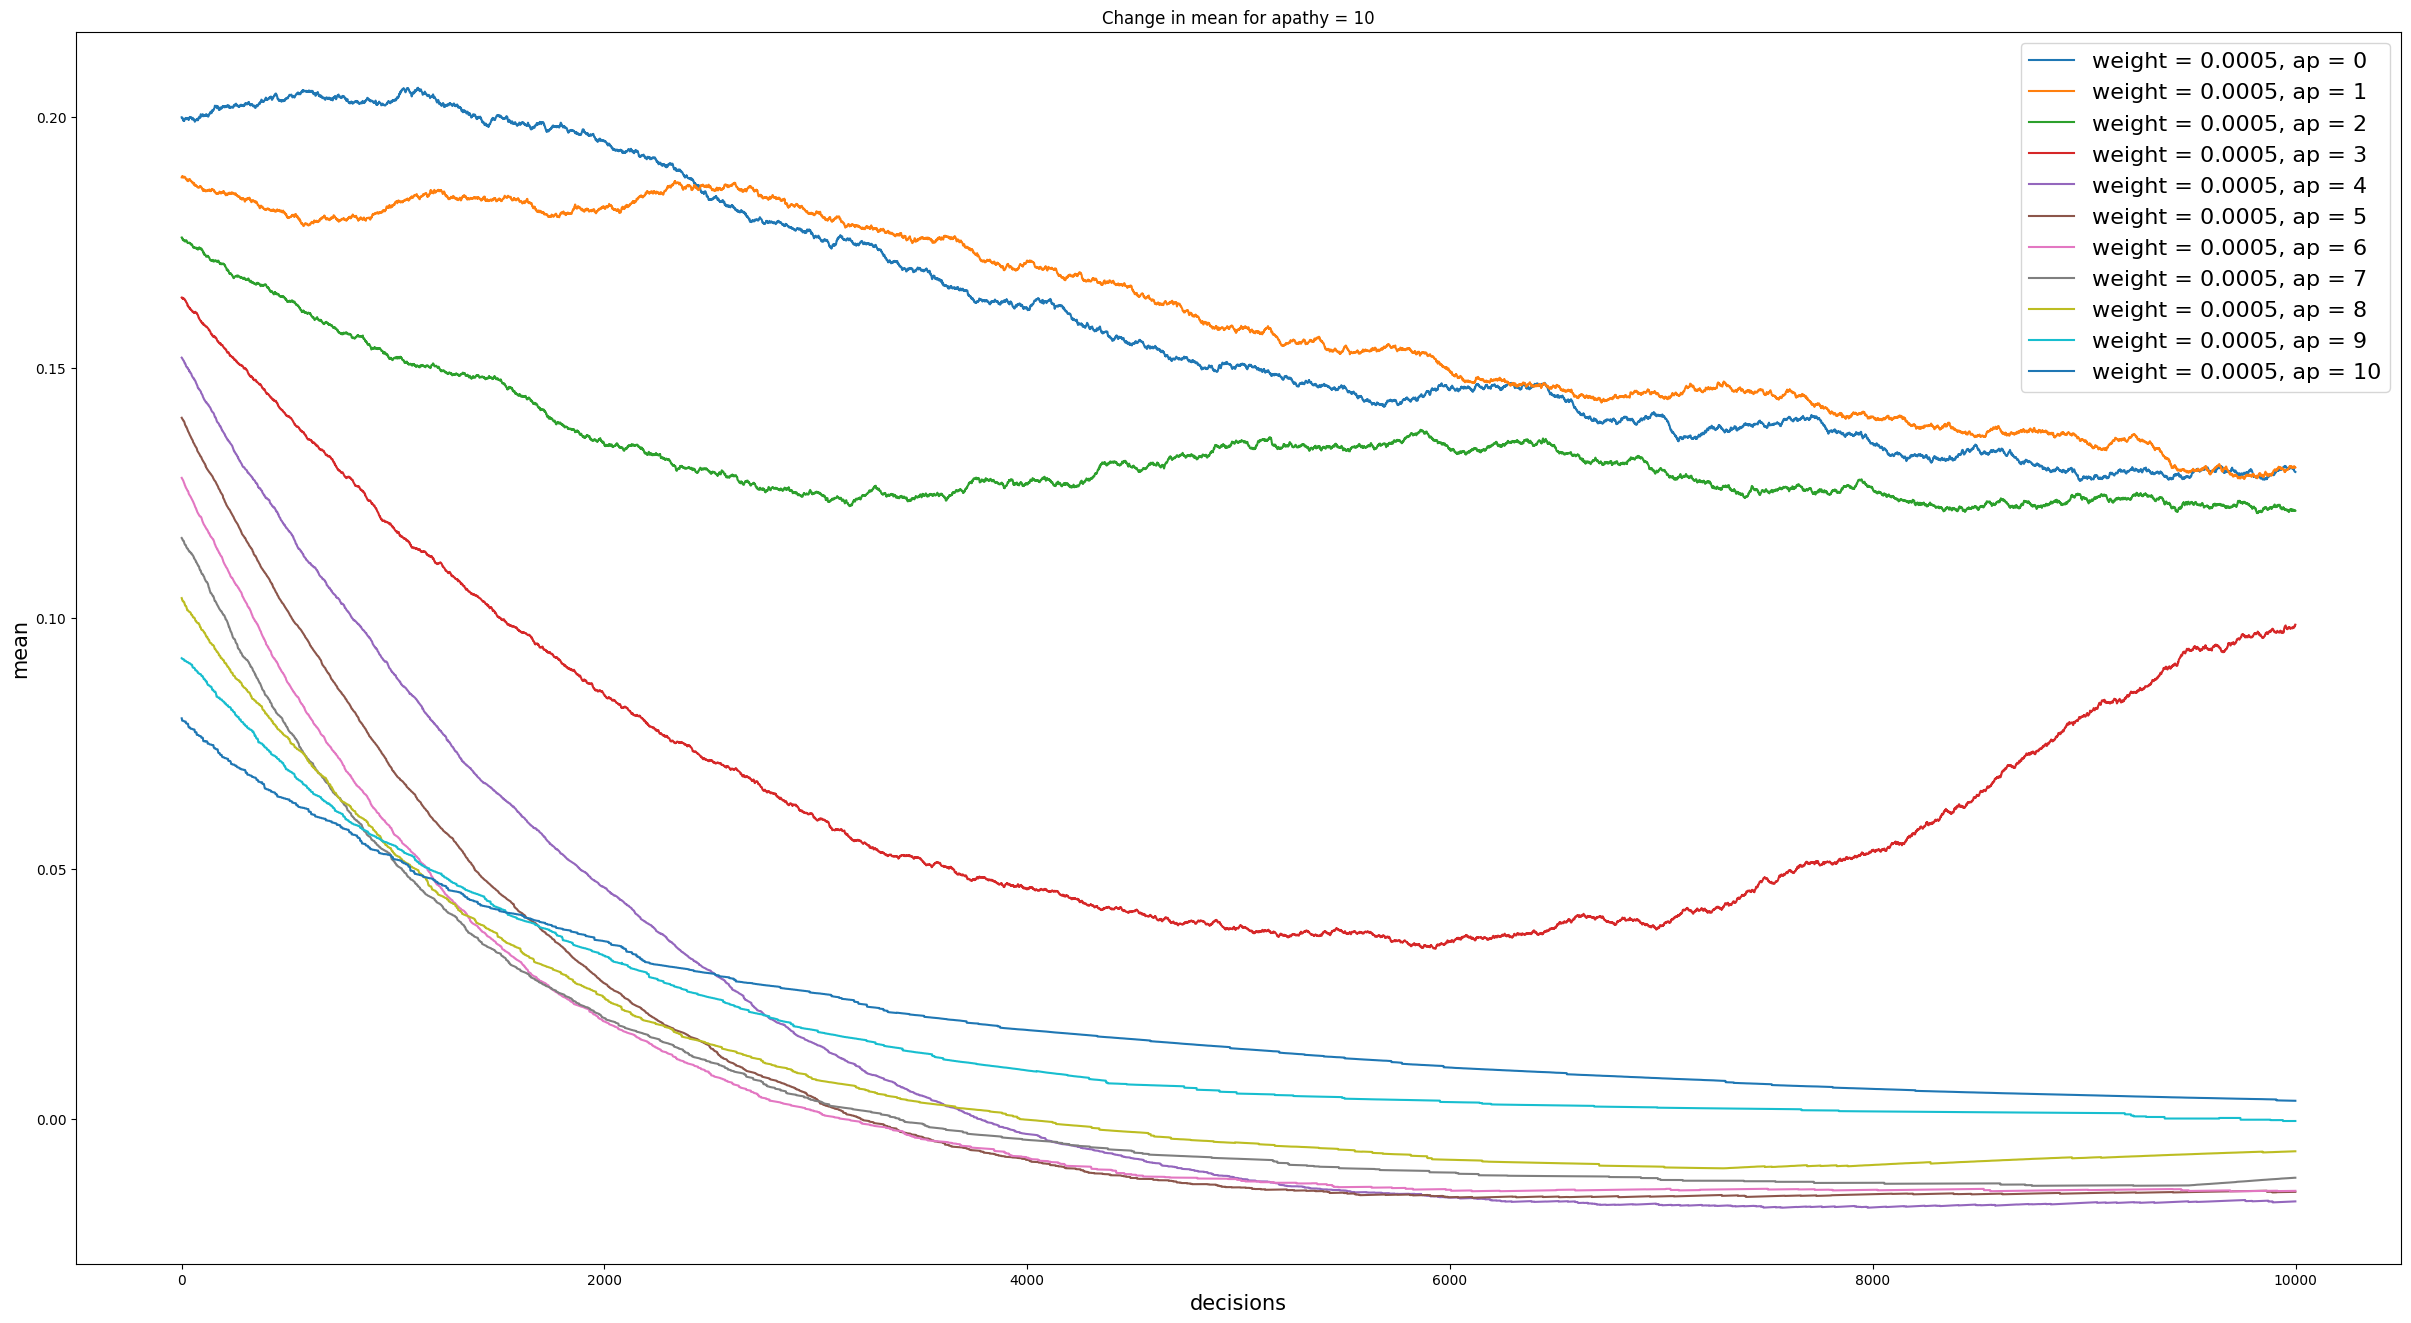

In [1136]:
days = 1000

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)

x = np.arange(0,days*10)


#ap=np.arange(0,11)
w = np.arange(0,0.002,0.0002)
w=[0.0005]
ap = np.arange(0,11,1)
#ap = [10]
for i in w:
    for j in ap:
        out = day_decisions(j , days, var, var_no, i)[0]
        plt.plot(x, out, label = 'weight = {}, ap = {}'.format(i,j))

plt.legend(prop={'size': 16})
plt.xlabel('decisions', fontsize='15')
plt.ylabel('mean', fontsize='15')
plt.title('Change in mean for apathy = 10')
plt.show()


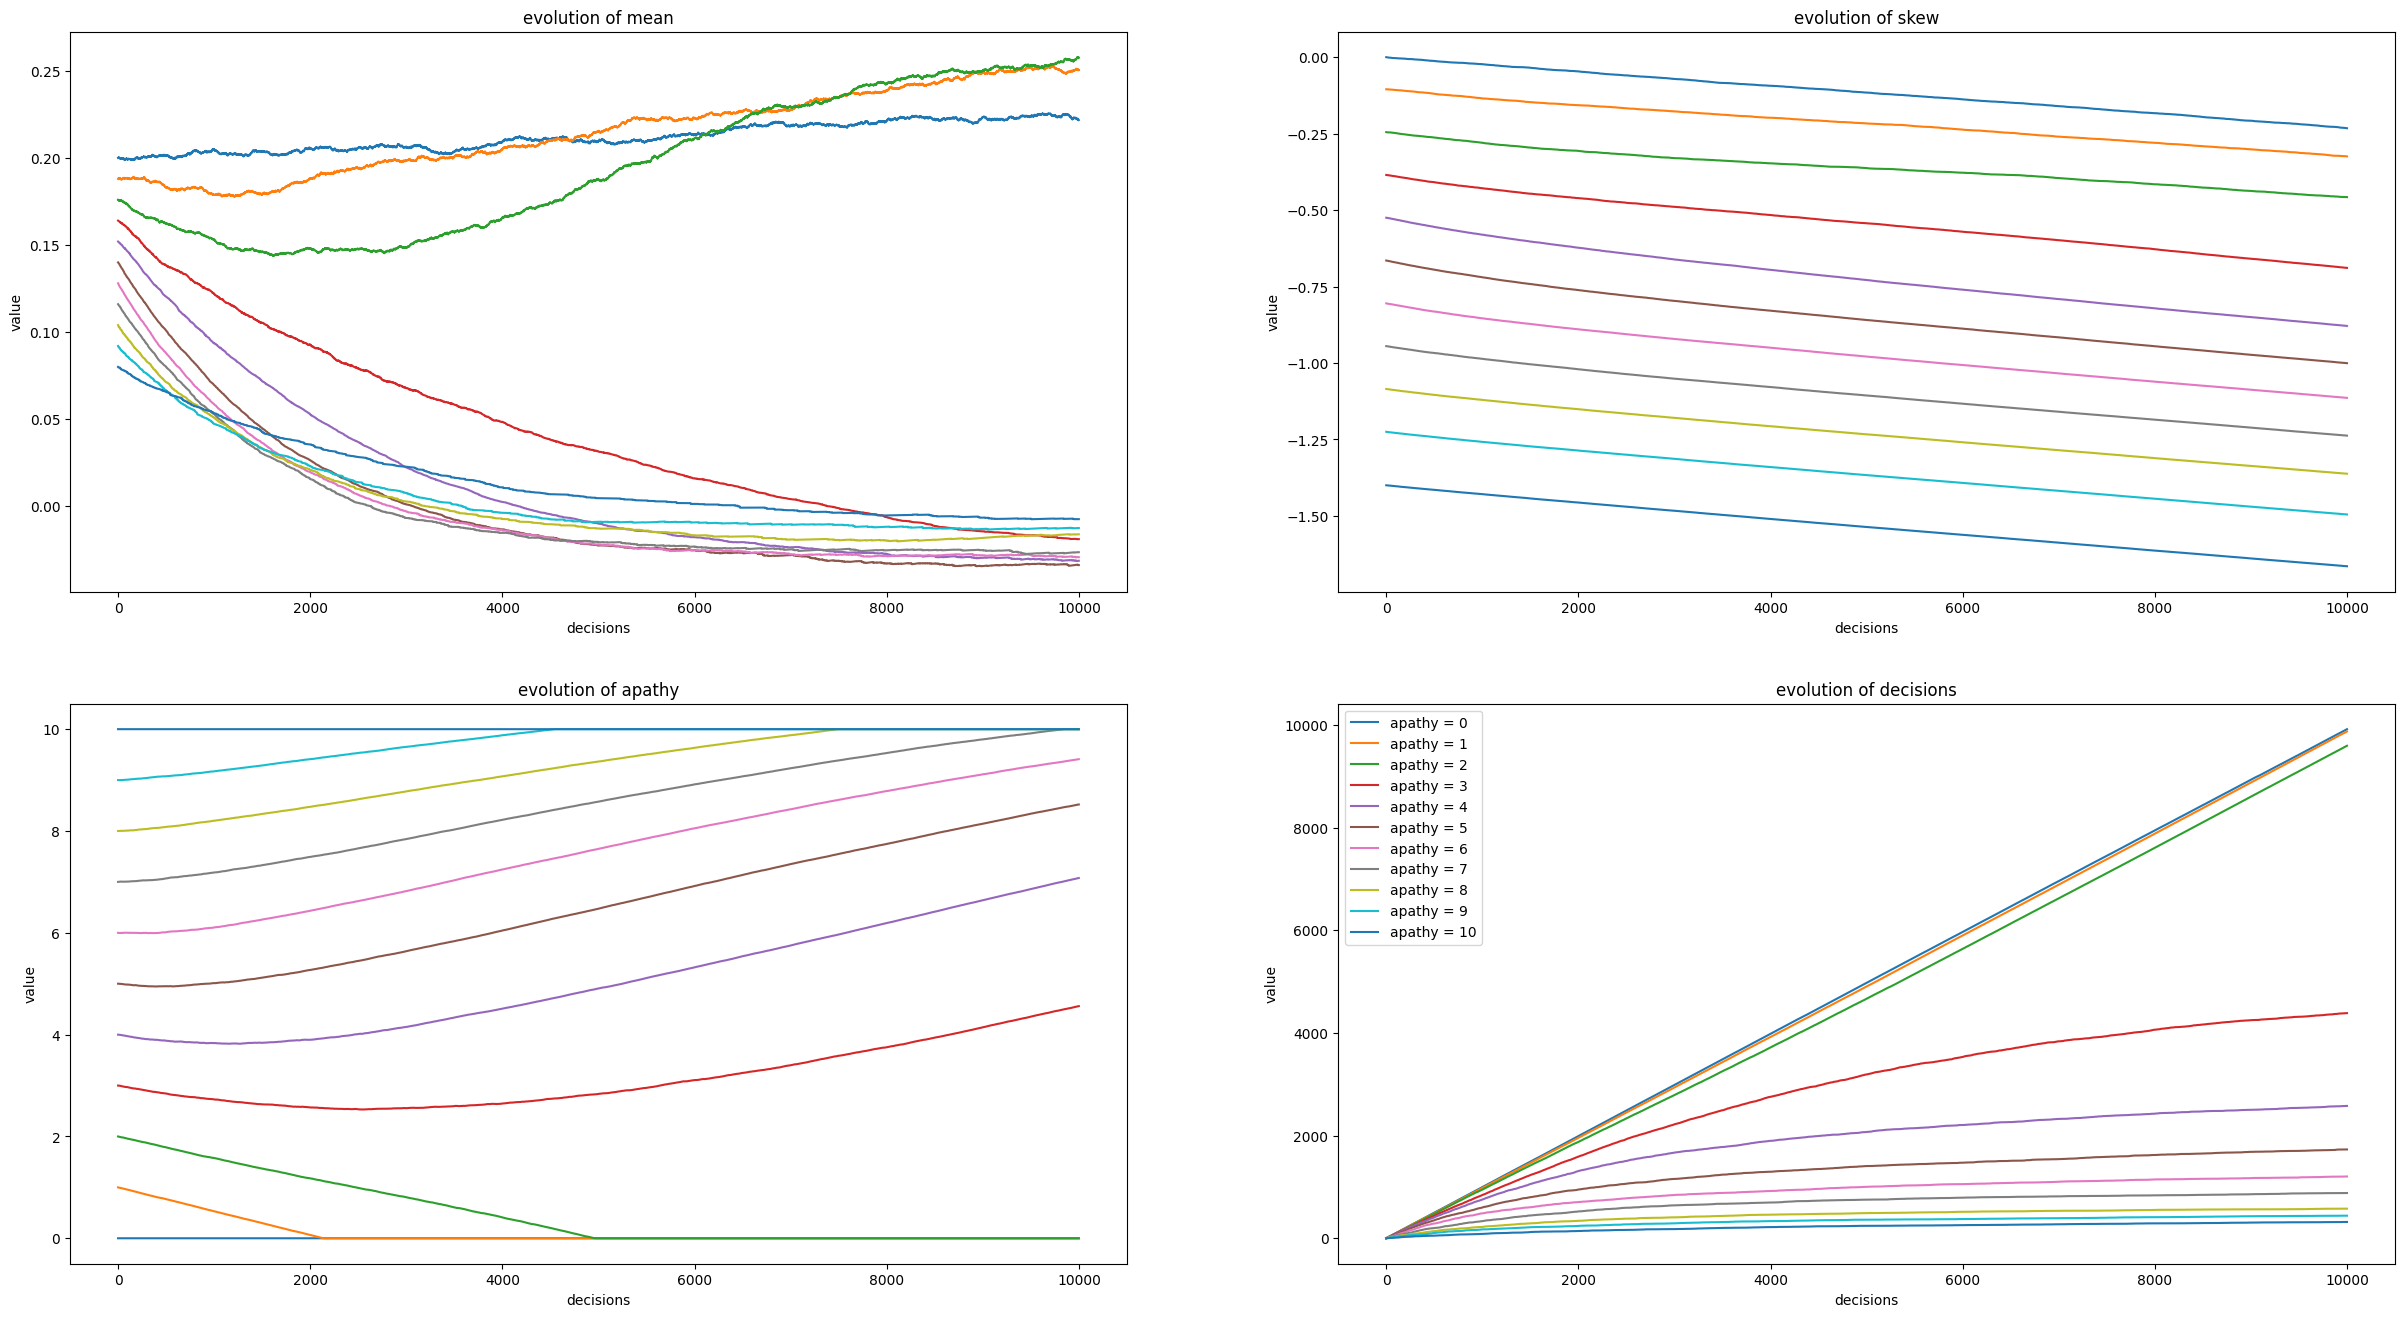

In [1149]:
days = 1000


plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(2, 2)
x = np.arange(0,days*10)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


for i in range(0,11):

    ap = i
    out = day_decisions(ap , days, var, var_no,0.0005)
   
    y1 = out[0]
    y2 = out[1]
    y3 = out[2]
    y4 = out[4]
    axs[0, 0].plot(x, y1,label = 'apathy = %d' %(ap))
    axs[0, 0].set_title('evolution of mean')
    axs[0, 1].plot(x, y2,label = 'apathy = %d' %(ap))
    axs[0, 1].set_title('evolution of skew')
    axs[1, 0].plot(x, y3,label = 'apathy = %d' %(ap))
    axs[1, 0].set_title('evolution of apathy')
    axs[1, 1].plot(x, y4,label = 'apathy = %d' %(ap))
    axs[1, 1].set_title('evolution of decisions')
plt.legend()
#need a balance in the apathy

2.669
173


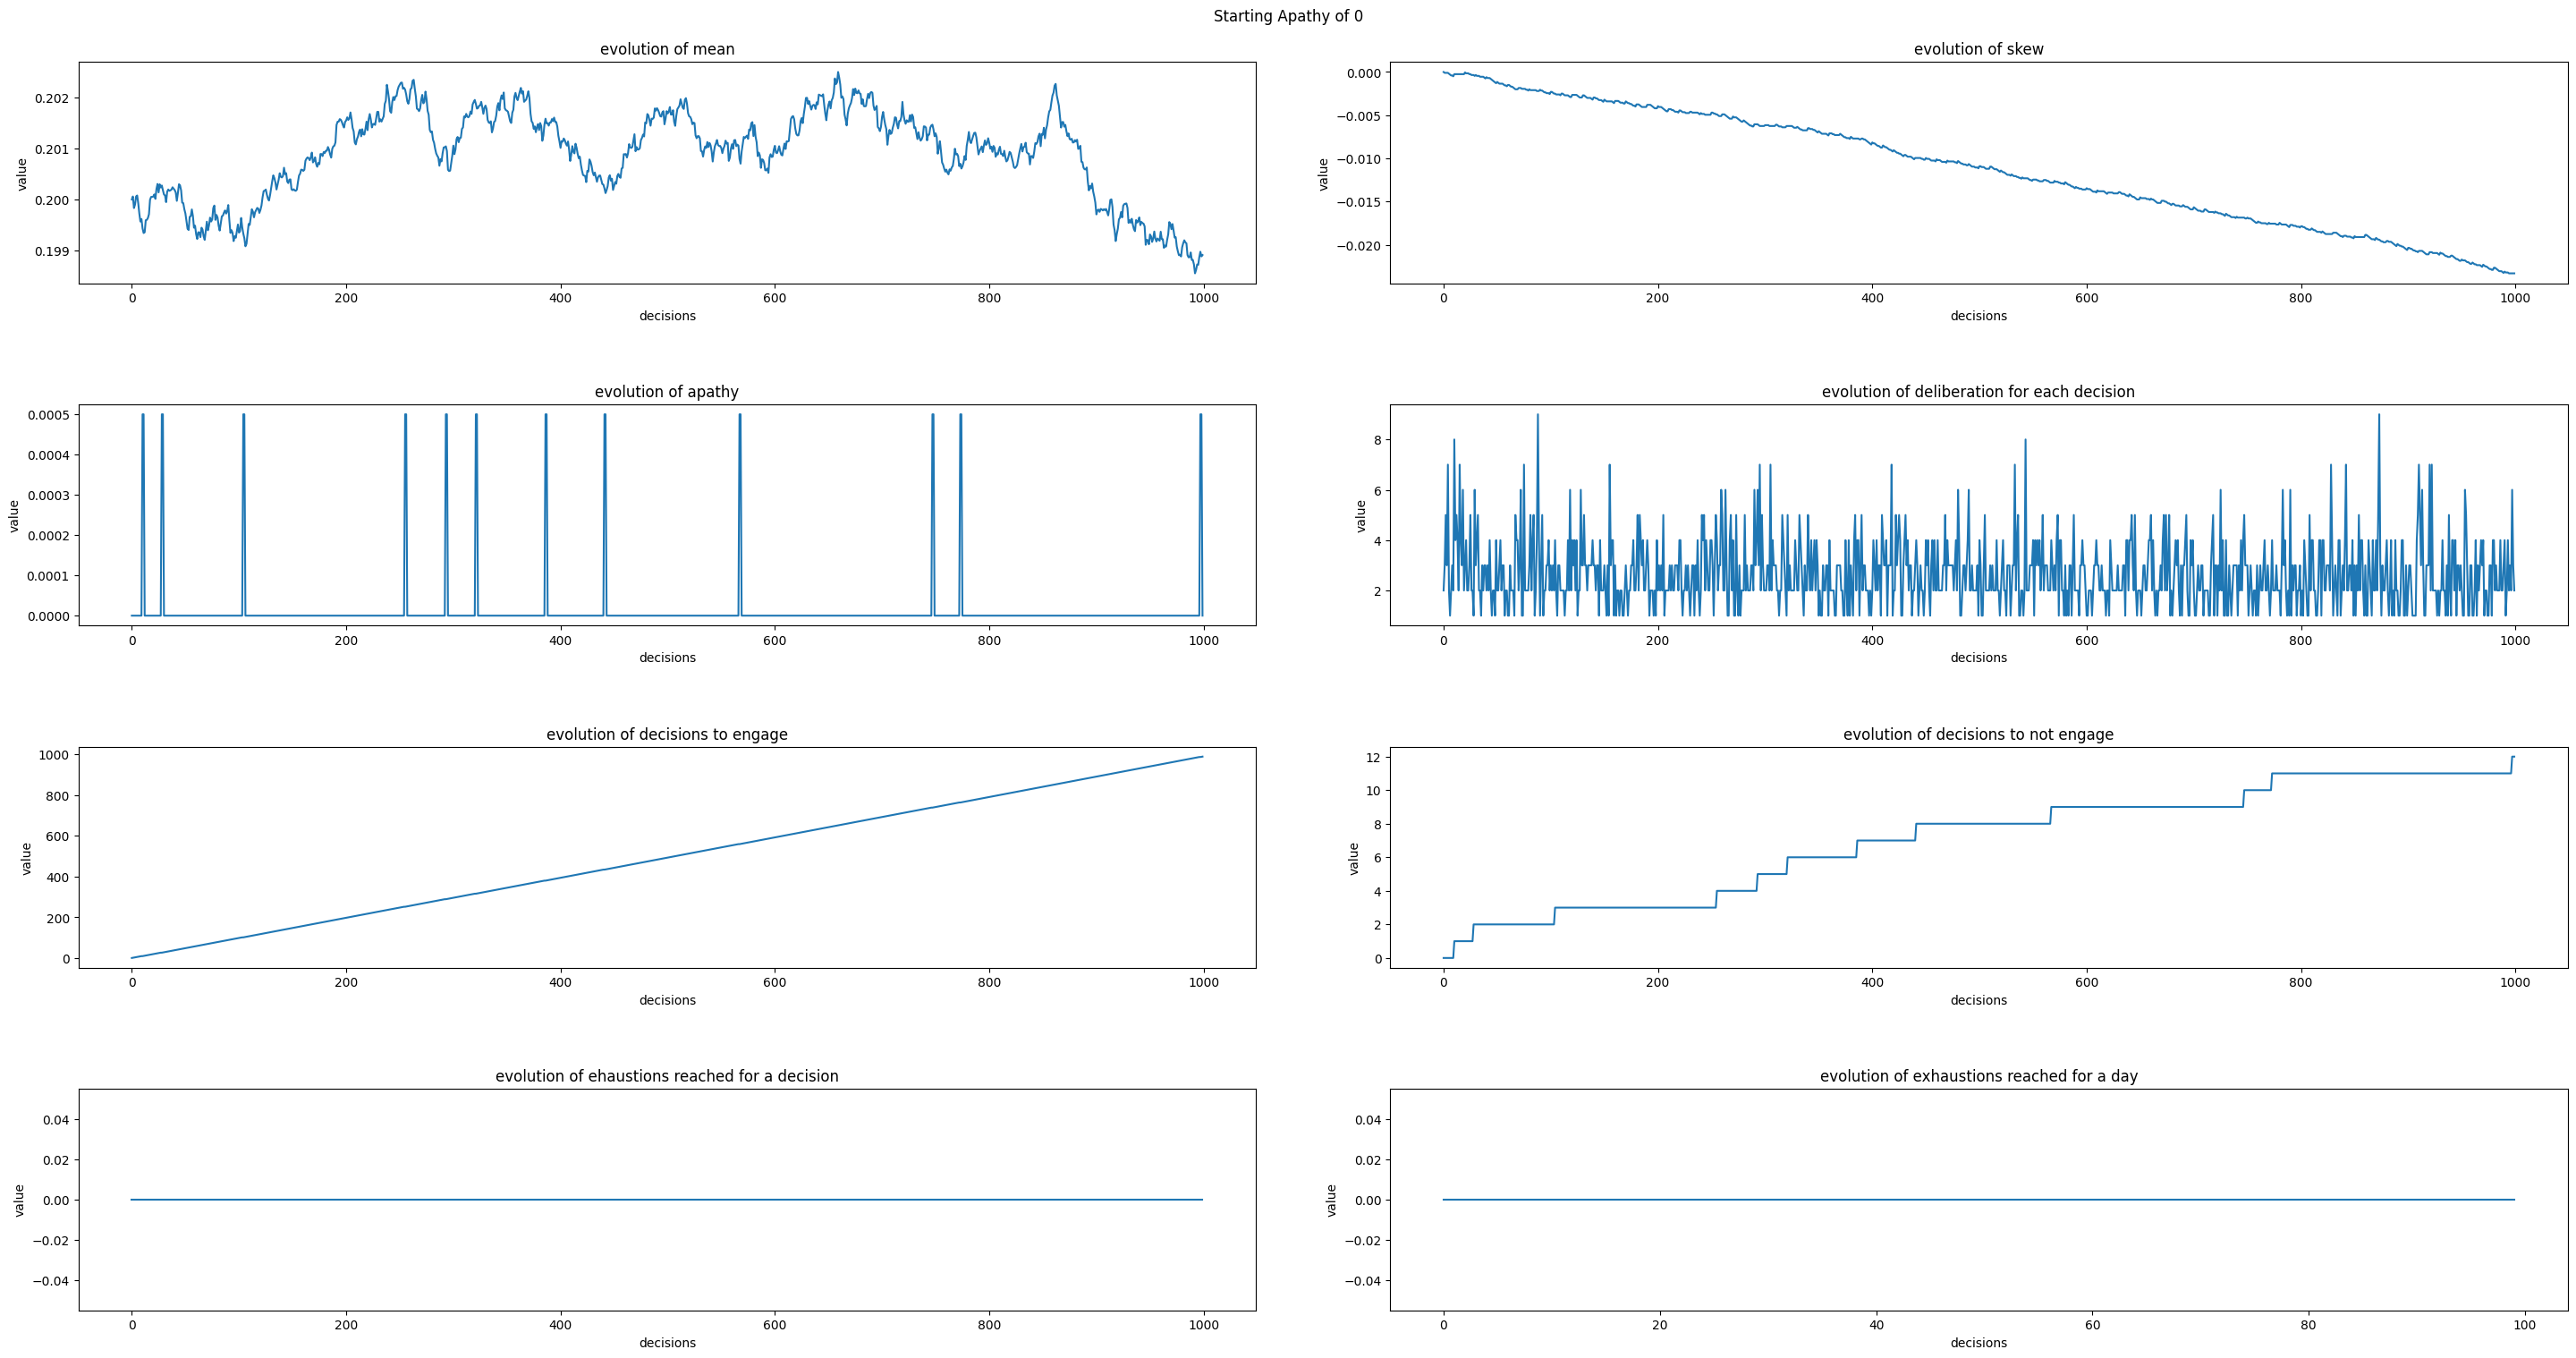

In [1148]:
days = 100

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,days*10)
x2 = np.arange(0,days)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 0
out =  day_decisions(0 , days, var, var_no, 0.0005)

y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
y8 = out[7]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of deliberation for each decision')
axs[2, 0].plot(x, y5)
axs[2, 0].set_title('evolution of decisions to engage')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of decisions to not engage')
axs[3, 0].plot(x, y7)
axs[3, 0].set_title('evolution of ehaustions reached for a decision')
axs[3, 1].plot(x2, y8)
axs[3, 1].set_title('evolution of exhaustions reached for a day')

fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 0')
print(np.average(y4))
count=0
for i in y4:
    if i ==1:
        count+=1
print(count)


2.734


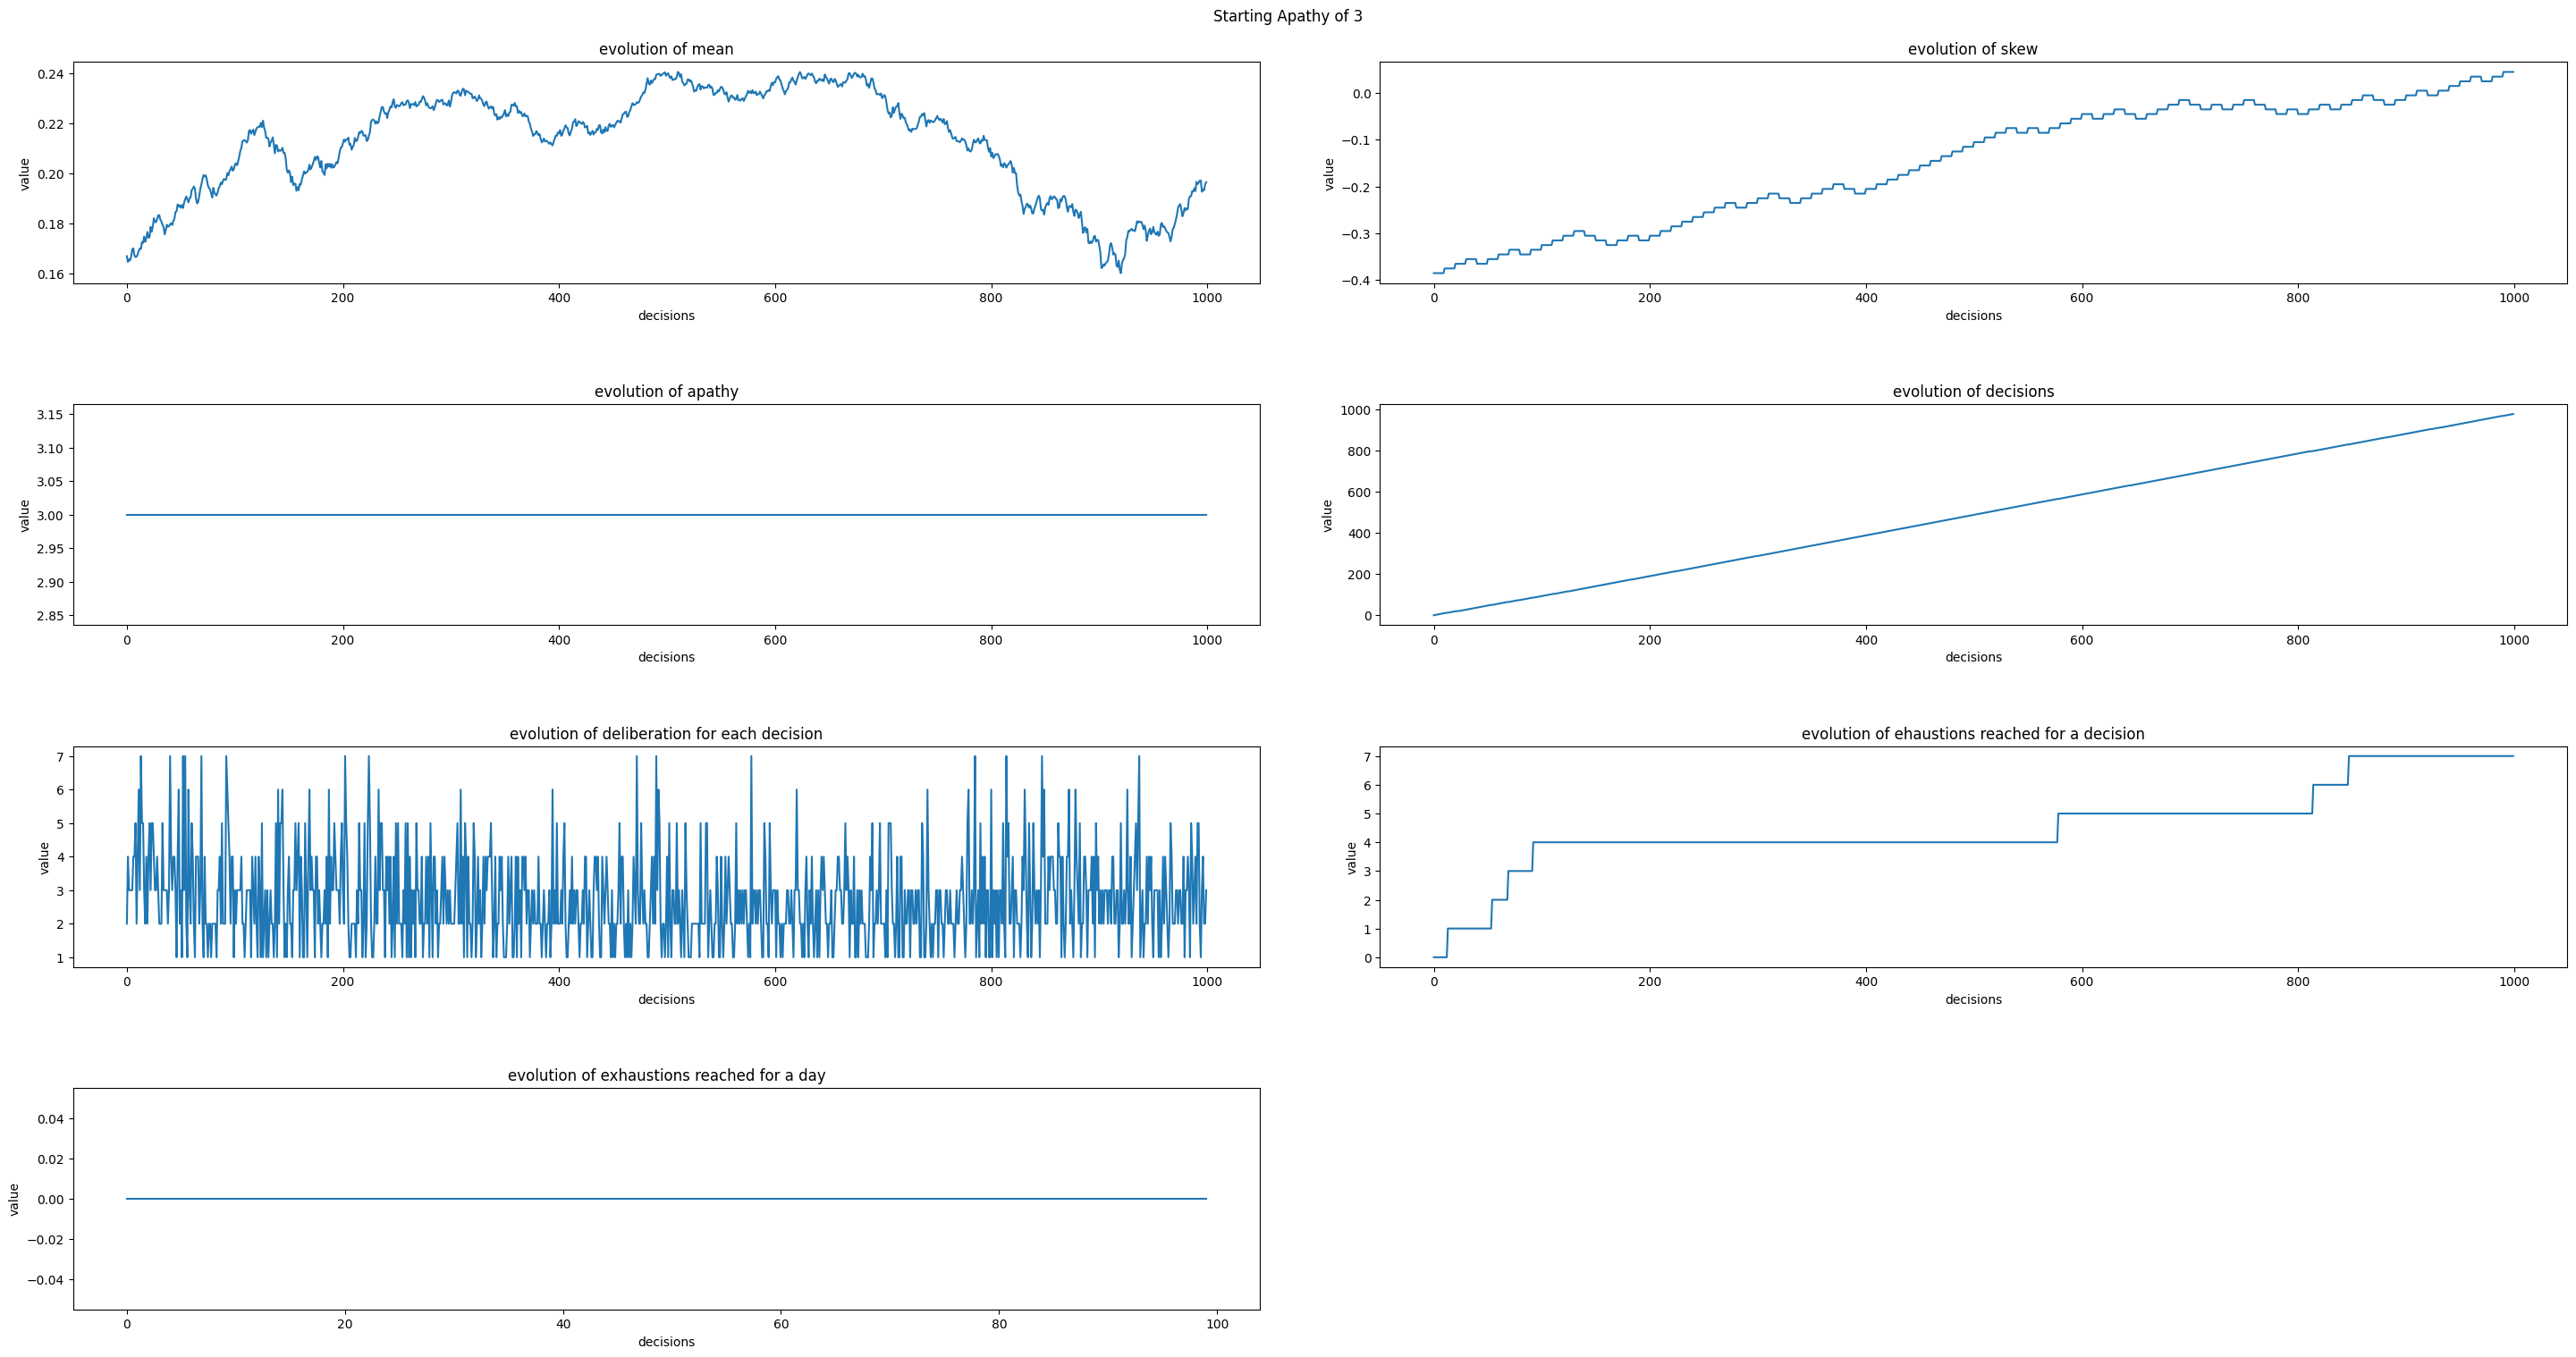

In [402]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 3

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 3')
print(np.average(y5))


4.2472361809045225


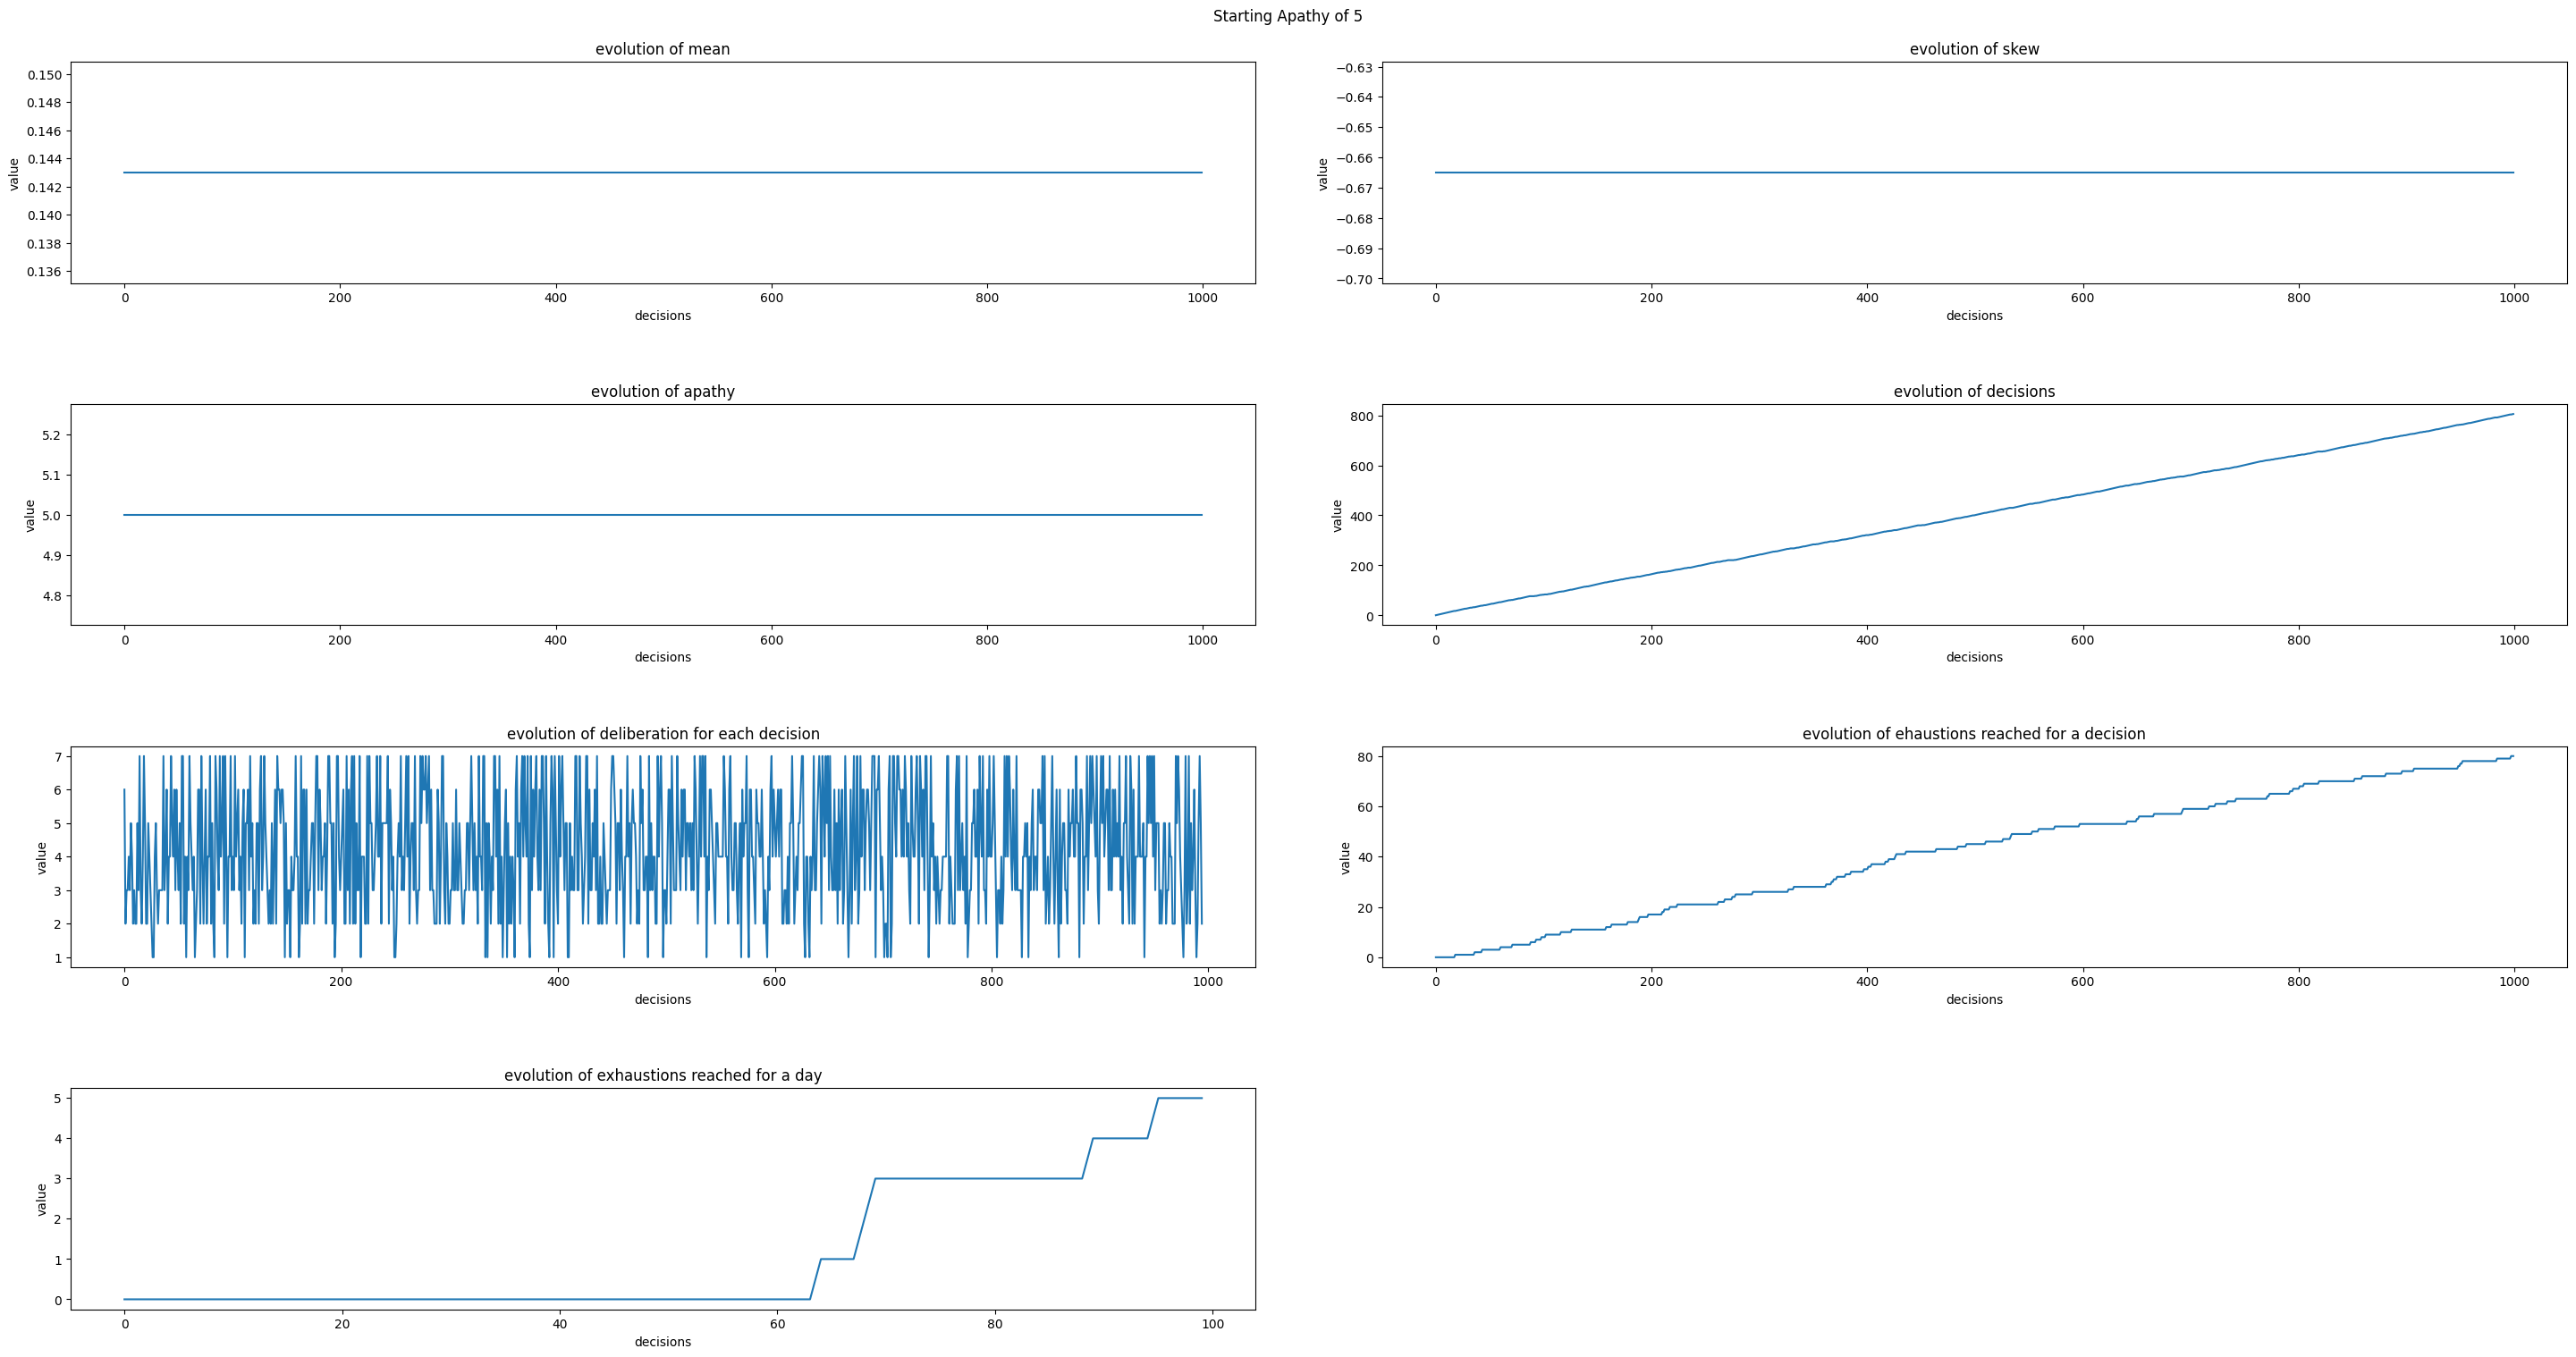

In [175]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 5

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 5')
print(np.average(y5))

4.862745098039215


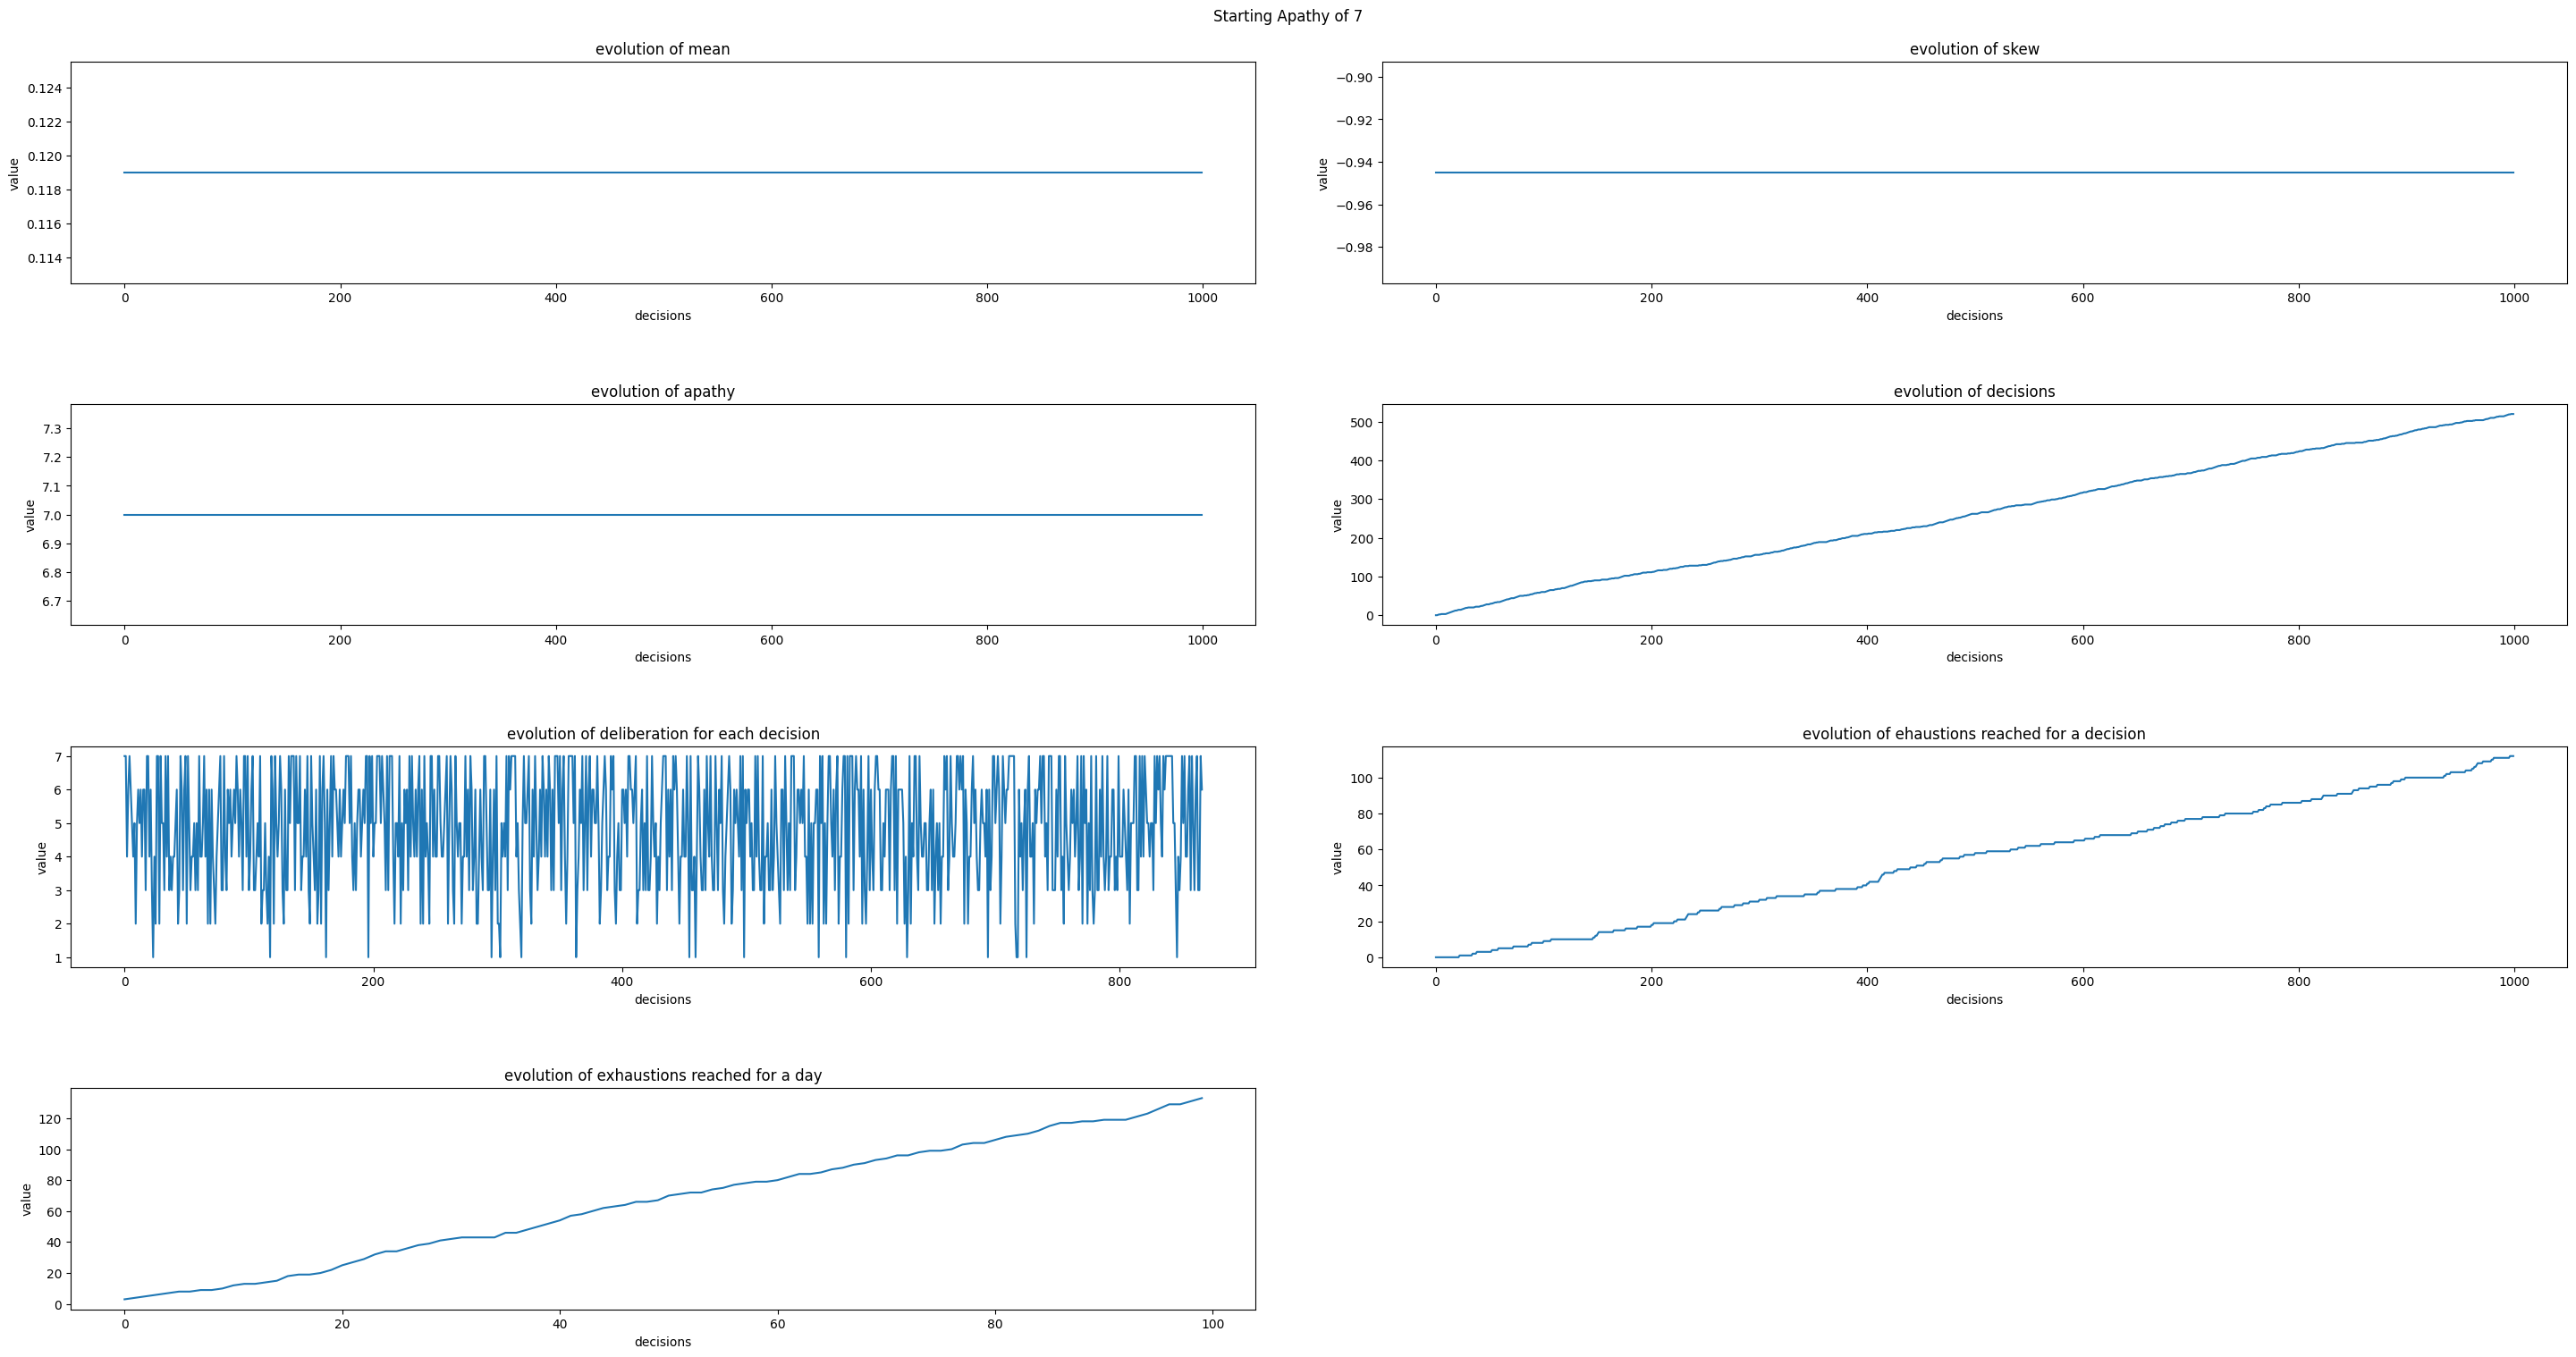

In [176]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 7

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 7')
print(np.average(y5))

5.149200710479573


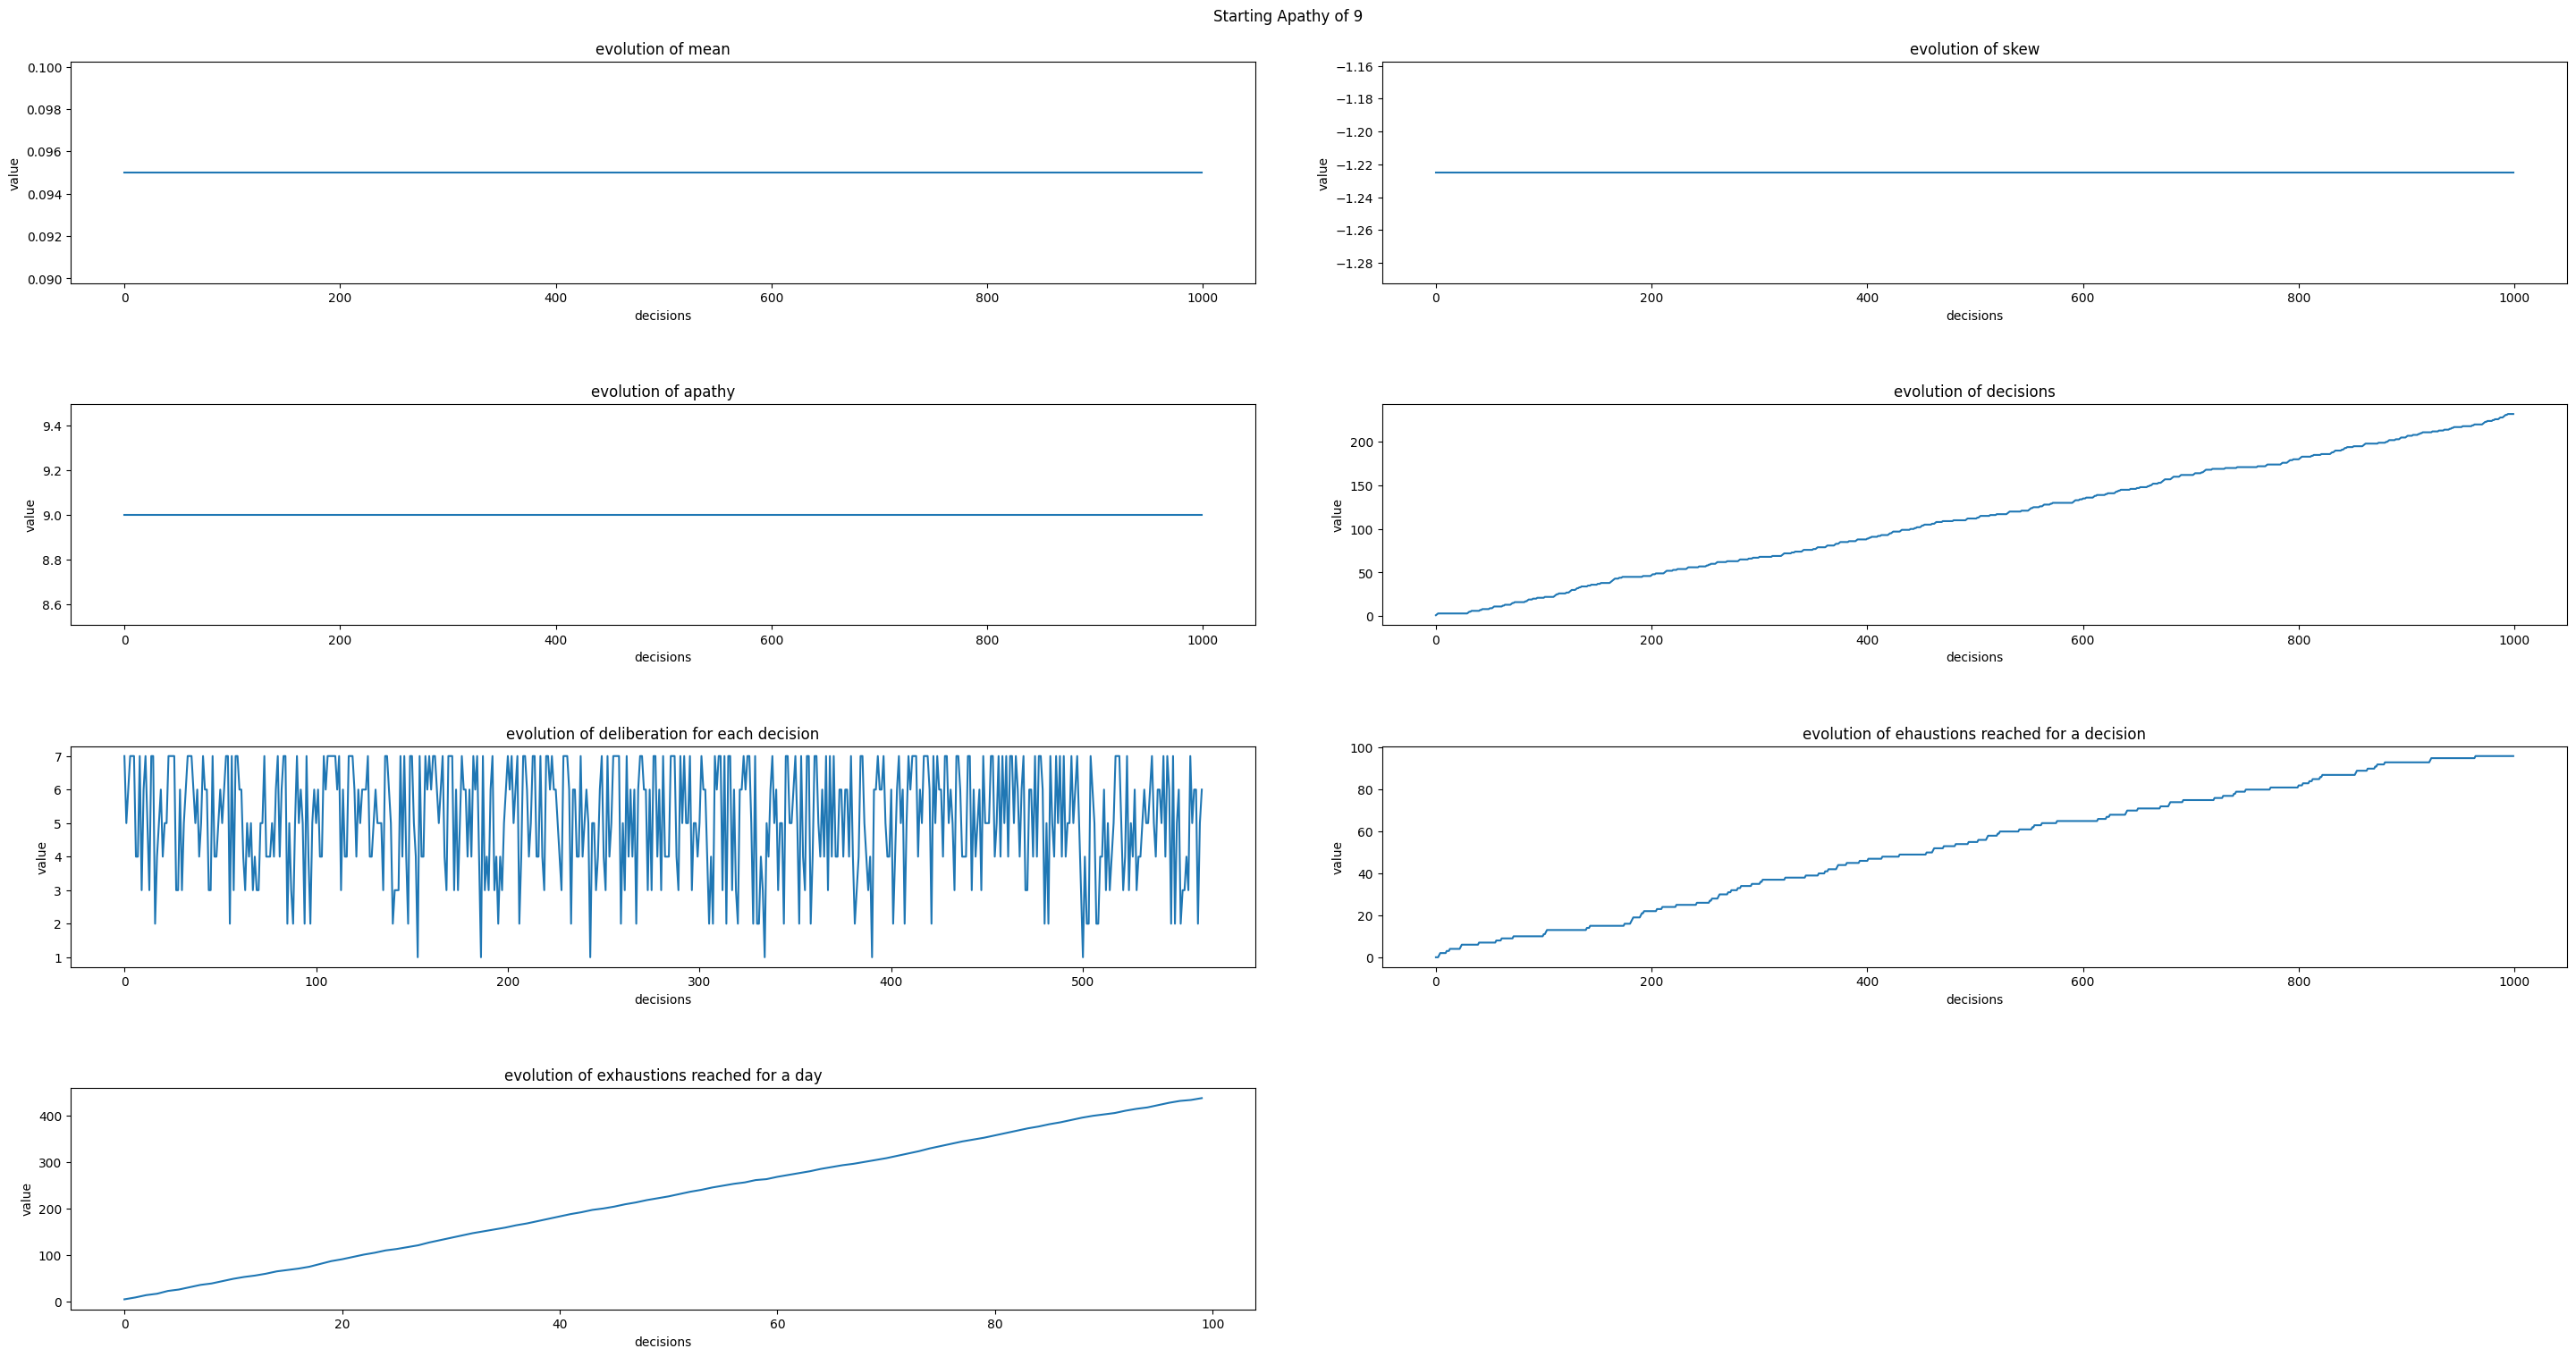

In [177]:

var,var_no  =0.2,0.1

plt.rcParams["figure.figsize"] = (30, 16)
fig, axs = plt.subplots(4, 2)
x = np.arange(0,100*10)
x2 = np.arange(0,100)
for ax in axs.flat:
    ax.set(xlabel='decisions', ylabel='value')


ap = 9

out = learn_sim_ap(ap , 100, pos_th, neg_th, en_th, var, var_no )
y1 = out[0]
y2 = out[1]
y3 = out[2]
y4 = out[3]
y5 = out[4]
x5 = np.arange(0,len(y5))
y6 = out[5]
y7 = out[6]
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('evolution of mean')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title('evolution of skew')
axs[1, 0].plot(x, y3)
axs[1, 0].set_title('evolution of apathy')
axs[1, 1].plot(x, y4)
axs[1, 1].set_title('evolution of decisions')
axs[2, 0].plot(x5, y5)
axs[2, 0].set_title('evolution of deliberation for each decision')
axs[2, 1].plot(x, y6)
axs[2, 1].set_title('evolution of ehaustions reached for a decision')
axs[3, 0].plot(x2, y7)
axs[3, 0].set_title('evolution of exhaustions reached for a day')
fig.delaxes(axs[3,1])
fig.tight_layout(pad=5.0)
fig.suptitle('Starting Apathy of 9')
print(np.average(y5))

In [893]:
var  =0.2
var_no= 0.1
tests = 1000
ap = np.linspace(0,10,21)

leng = len(ap)

vals = np.empty([2,leng])
vals[0] = ap
for i in range(leng):
    a = ap[i]
    ys = 0
    start = initial(a,mean_interval,0.14,mean_overlap,skew_overlap)
    sk = start[1]
    m1 = 0.15
    m2 = 0.015
    mn = mean(a,m1,m2)
    '''for _ in range(tests):
        ys+=sim_ap_learn(pos_th, neg_th, en_th, var, var_no ,mn,sk, a)[1]  '''
    ys = learn_sim_ap_param(a , days, pos_th, neg_th, en_th, var, var_no,0.1)[3][-1]
    vals[1][i] = ys
    #skew_interval = 0.14

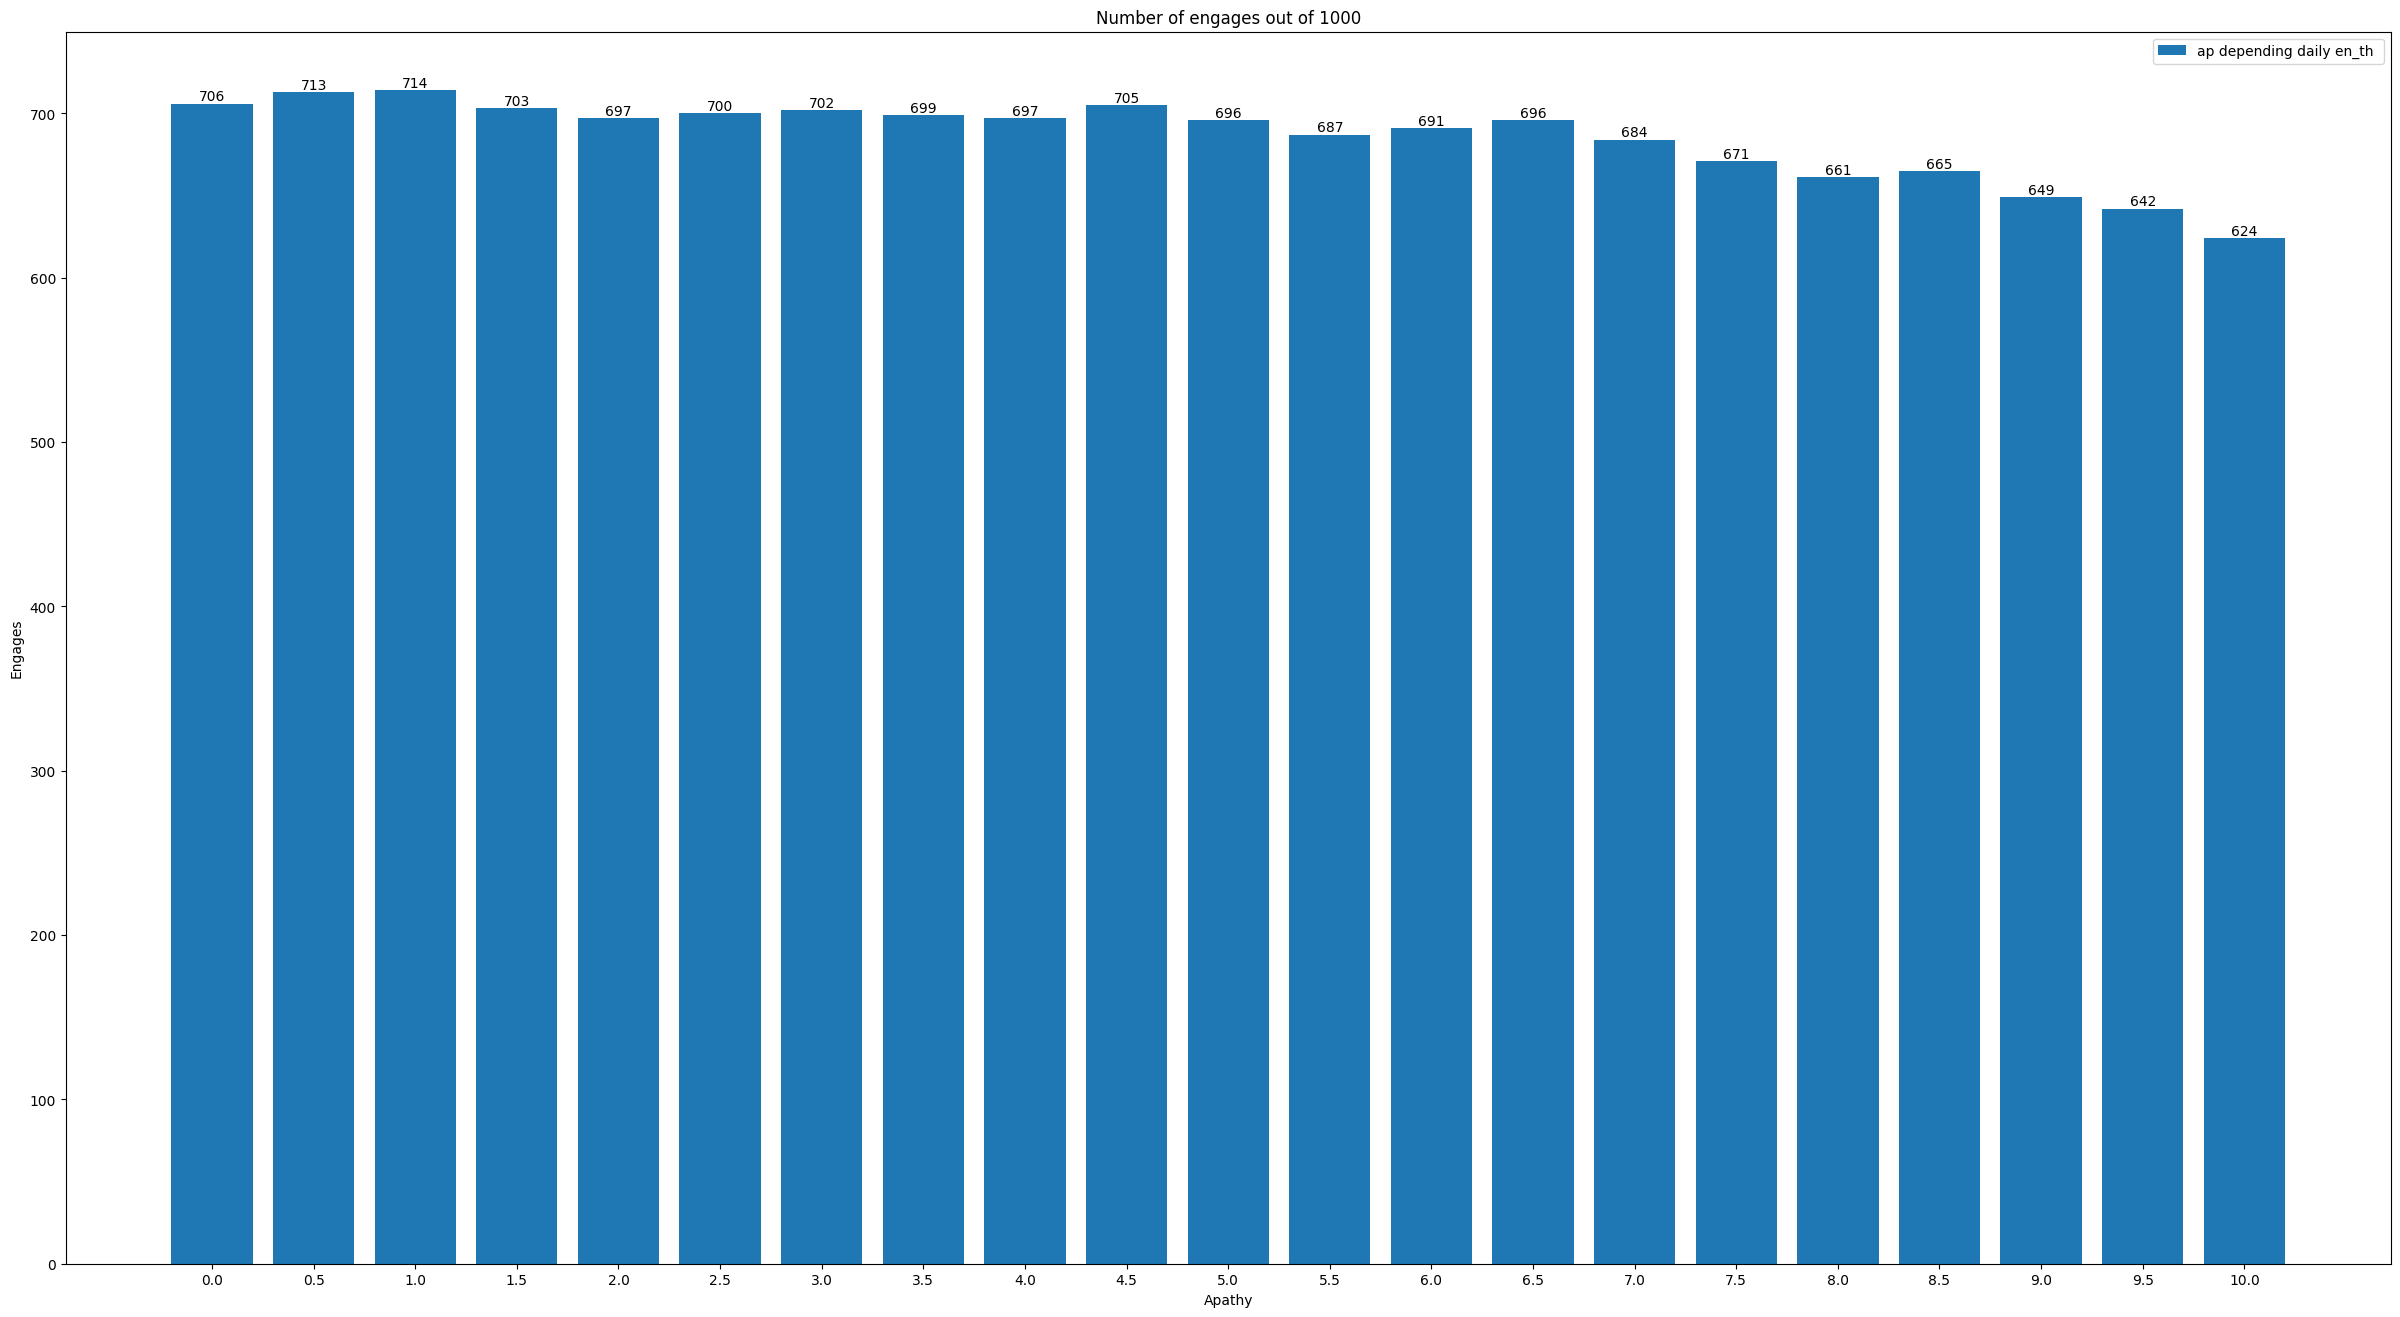

In [894]:
X_axis = np.arange(len(vals[0]))


plt.rcParams["figure.figsize"] = (30, 16)


bar_1 = plt.bar(X_axis, vals[1], label = 'ap depending daily en_th ')
plt.bar_label(bar_1)
plt.xticks(X_axis, vals[0])
plt.xlabel("Apathy")
plt.ylabel("Engages")
plt.title("Number of engages out of 1000")
plt.legend()
plt.show()